### Import Libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline  
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve

In [28]:
df = pd.read_csv('./dataset/processed_dataset.csv')

df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
96141,0,36.0,0,0,0,24.60,4.8,145,0
96142,0,2.0,0,0,0,17.37,6.5,100,0
96143,1,66.0,0,0,3,27.83,5.7,155,0
96144,0,24.0,0,0,4,35.42,4.0,100,0


In [29]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# Verify the remaining features in X
print("Features for model building:")
print(X.columns)

Features for model building:
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')


In [30]:
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Define the pipeline with SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('adaboost', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9), algorithm='SAMME'))
])

In [32]:
# 4. Define parameters for GridSearch
param_grid = {
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1.0],
    'adaboost__estimator__max_depth': [1, 2, 3]
}

In [33]:
# Perform GridSearchCV with the imbalanced-learn pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('adaboost',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           estimator=DecisionTreeClassifier(max_depth=9)))]),
             n_jobs=-1,
             param_grid={'adaboost__estimator__max_depth': [1, 2, 3],
                         'adaboost__learning_rate': [0.01, 0.1, 1.0],
                         'adaboost__n_estimators': [50, 100, 200]},
             scoring='f1')

In [34]:
# 6. Get best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

In [35]:
# 7. Print model evaluation
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'adaboost__estimator__max_depth': 2, 'adaboost__learning_rate': 0.01, 'adaboost__n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     26267
           1       1.00      0.68      0.81      2577

    accuracy                           0.97     28844
   macro avg       0.98      0.84      0.90     28844
weighted avg       0.97      0.97      0.97     28844



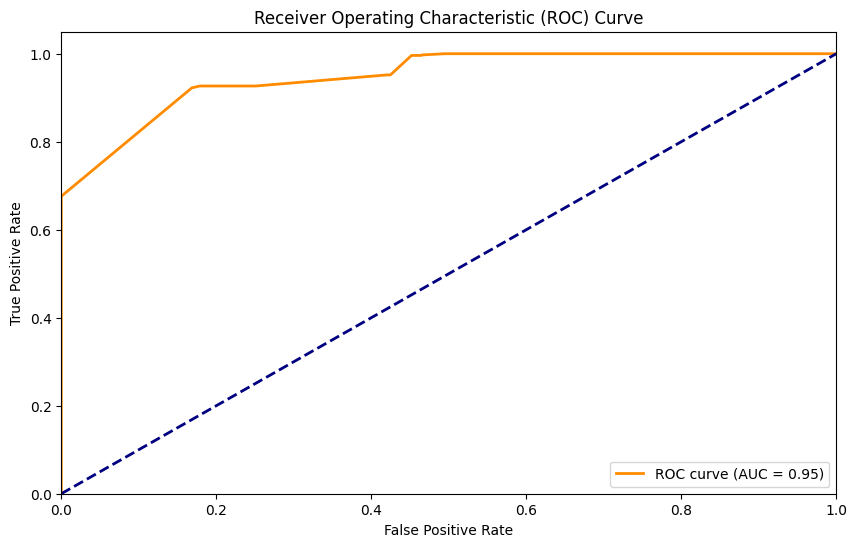

In [36]:
# 8. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

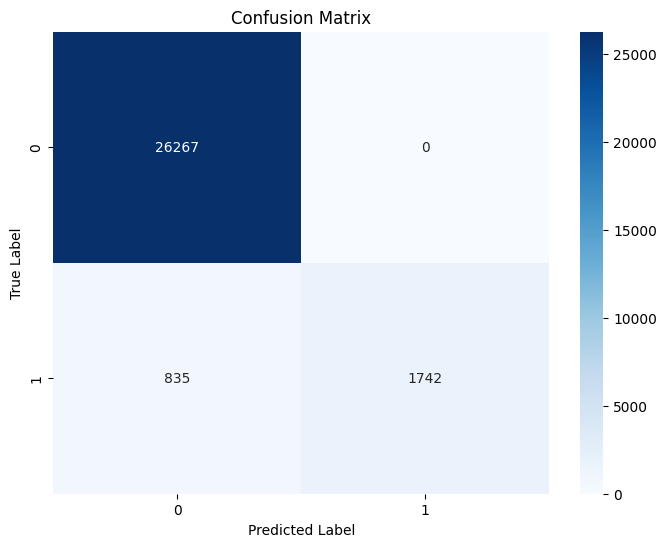

In [37]:
# 9. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

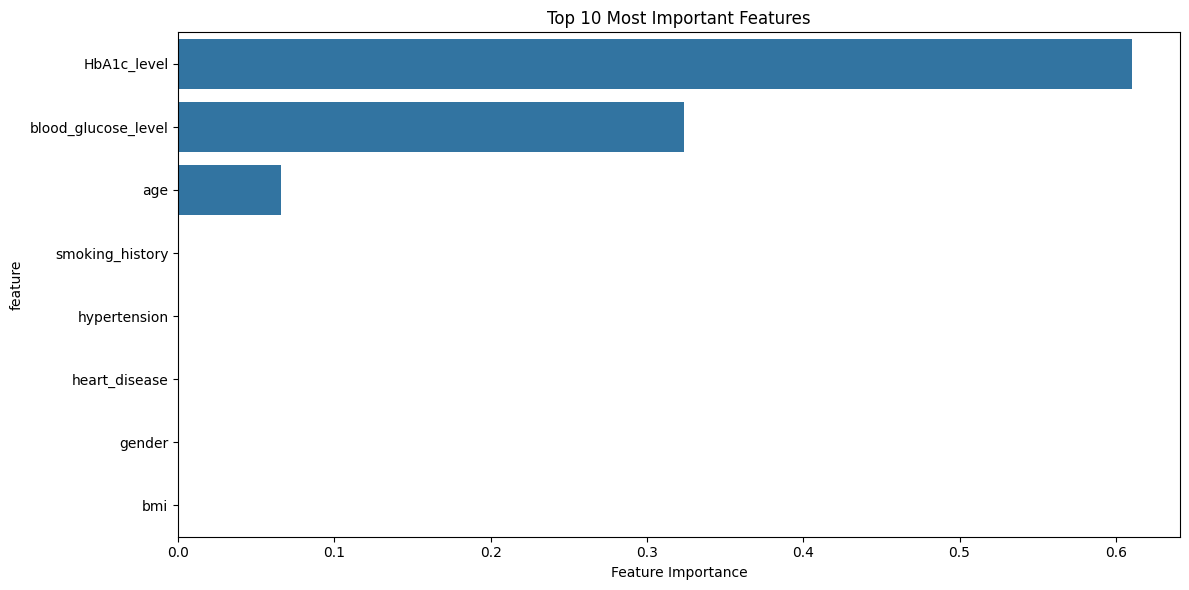

In [38]:
# 10. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.named_steps['adaboost'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

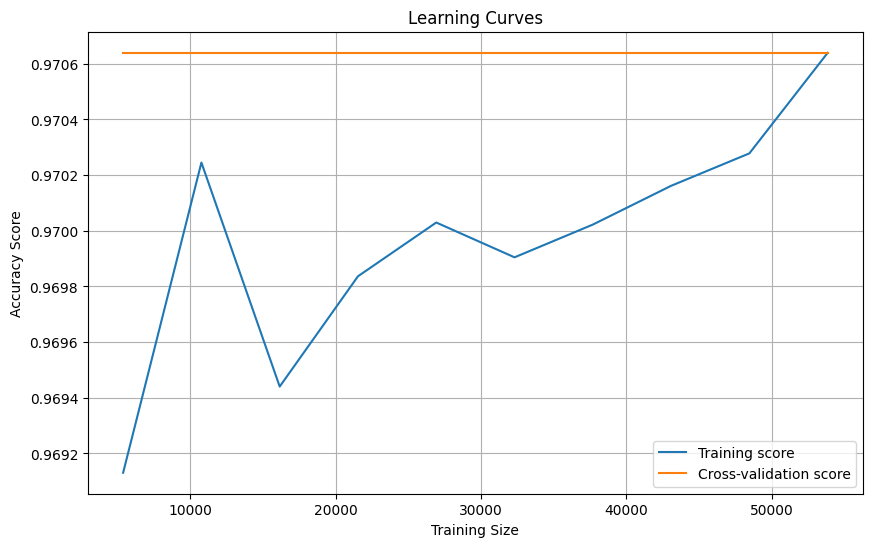

In [39]:
# 11. Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()